In [1]:

import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data
        

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

workspace_path = Path(os.getcwd()).parent.parent

# Load data

In [2]:
person_data = pd.read_csv(f'{workspace_path}/data/summit/data/person_data.csv', low_memory=False)
nodule_data = pd.read_csv(f'{workspace_path}/data/summit/data/nodule_data.csv')

# Cluster analysis split by Gender & Ethnicity

In [ ]:
person_data['IMDRank_tertile'] = pd.qcut(person_data['ocd_DeprivationScore_IMDRank'], 3, labels=['1. Low', '2. Medium', '3. High'])
person_data['IMDRank_quintile'] = pd.qcut(person_data['ocd_DeprivationScore_IMDRank'], 5, labels=['1. Low', '2. Low-Medium', '3. Medium', '4. Medium-High', '5. High'])


# IMD Rank Tertile
person_data['IMDRank_tertile'].value_counts(dropna=False).sort_index()
person_data['IMDRank_quintile'].value_counts(dropna=False).sort_index()

In [3]:

categorical_dict = {
    'radiology_report_nodule_site' : 'site',
    'radiology_report_nodule_type' : 'type',
    'radiology_report_management_plan' : 'management_plan',
    'IMDRank_quintile' : 'IMD Rank Quintile'
}

numerical_dict = {
    'radiology_report_nodule_diameter_mm' : 'diameter',
    'lung_health_check_clinical_smoking_pack_years' : 'smoking_pack_years'
}

In [4]:
import numpy as np
import cv2
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from scipy import stats

def hist_comparison(data1, cat1, data2, cat2, bins, title, variable, density=True):

    hist1, bins1 = np.histogram(data1[variable], bins=bins, density=True)
    hist2, bins2 = np.histogram(data2[variable], bins=bins, density=True)

    hist1 = cv2.normalize(hist1, hist1).astype(np.float32)
    hist2 = cv2.normalize(hist2, hist2).astype(np.float32)

    print(f'Histogram comparison for {variable} for {title}')
    print(f'Correlation between {variable} and nodule diameter for {title} is {cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)}')

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].hist(data1[variable], bins=bins, density=density, alpha=0.6, color='red')
    ax[0].set_title(f'{variable} for {cat1} ppts')
    if density:
        ax[0].set_xlim(0, 80)
        ax[0].set_ylim(0, 0.2)


    ax[1].hist(data2[variable], bins=bins, density=density, alpha=0.6, color='blue')
    ax[1].set_title(f'{variable} for {cat2} ppts')
    if density:
        ax[1].set_xlim(0, 80)
        ax[1].set_ylim(0, 0.2)
    

    fig.suptitle(title)
    plt.show()

def differences_bar_chart(data1, cat1, data2, cat2, variable, title):

    values1 = data1[variable].value_counts(normalize=True).sort_index().rename(f'{variable}_{cat1}').to_frame()
    values2 = data2[variable].value_counts(normalize=True).sort_index().rename(f'{variable}_{cat2}').to_frame()

    values = values1.merge(values2, left_index=True, right_index=True, how='outer').fillna(0)

    # Calculate differences
    differences = values[f'{variable}_{cat1}'] - values[f'{variable}_{cat2}']

    display(differences)

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(differences.index, differences, color=['blue' if value < 0 else 'red' for value in differences])


    # Add labels and title
    ax.set_xticklabels(differences.index, rotation=45)
    ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Difference')
    ax.set_title(f'Difference Bar Chart: {variable}')
    # Function to format y-tick labels as percentages with sign
    def percentage_with_sign(x, pos):
        return f'{np.abs(x)*100:.0f}%'

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_with_sign))


    positive_patch = Patch(color='red', label=f'{cat1} greater than {cat2}')
    negative_patch = Patch(color='blue', label=f'{cat2} greater than {cat1}')
    ax.legend(handles=[positive_patch, negative_patch])

    # Show the plot
    plt.show()

def chi_square_test(data1, cat1, data2, cat2, variable):
    # Create the crosstab with absolutes
    xabs = (
        pd.DataFrame(
            data1[variable]
            .value_counts()
            .sort_index()
        )
        .merge(
            pd.DataFrame(
                data2[variable]
                .value_counts()
                .sort_index()
            ),
            left_index=True,
            right_index=True,
            how='outer',
            suffixes=('_'+cat1, '_'+cat2))
        .fillna(0)
    ).astype(int)

    # Calculate the chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(xabs)

    print(f'Chi-square test for {variable} between {cat1} and {cat2}')
    print(f'Chi2: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies table:')
    display(pd.DataFrame(expected, index=xabs.index, columns=xabs.columns))

    return chi2, p, dof, expected

# Person Level Comparisons Across Protected Groups

In [34]:
person_data.head()

,Unnamed: 0,LDCT_RADIOLOGY_REPORT_main_form_instance_id,LDCT_RADIOLOGY_REPORT_main_form_instance_status,LDCT_RADIOLOGY_REPORT_main_participant_id,radiology_report_incidental_coronary_calcium_cir,radiology_report_incidental_coronary_calcium_lmlad,radiology_report_incidental_coronary_calcium_rca,radiology_report_incidental_family_history_of_lung_cancer,radiology_report_incidental_mediastinal,radiology_report_incidental_mediastinal_enum_anterior_mediastinal_mass,...,participant_age_at_consent,participant_age_at_consent_cats,mpi_ParticipantMetadata_EthnicGroup,mpi_ParticipantMetadata_EthnicCategory,mpi_ParticipantMetadata_EthnicCategoryStr,lung_health_check_demographics_race_ethnicgroup,nodule_count,nodule_count_cats,IMDRank_tertile,IMDRank_quintile
0,0,yGaZ-aYjsvx1ElSOfQ5o_DGQnArqs1vqqUKuyO6NZDE,COMPLETED,summit-2222-djr,NONE,NONE,NONE,NOT_ANSWERED,NONE,False,...,55,55-59,1.0,1.0,White,White,3.0,3 Nodules,2. Medium,2. Low-Medium
1,1,EGRJ945atCAaxP_RkspELNfzyrSAQlWCSLqhOTHzBYg,COMPLETED,summit-2222-zmd,MILD,NONE,MILD,NOT_ANSWERED,NONE,False,...,70,70-75,1.0,1.0,White,White,1.0,1 Nodule,3. High,5. High
2,2,SEo0oLfS3K7NzN9imjFCe9VtLxMMaD5Jv5mVyg8zhok,COMPLETED,summit-2223-rvs,NONE,MODERATE,NONE,NOT_ANSWERED,NONE,False,...,69,65-69,2.0,1.0,White,White,0.0,0 Nodules,2. Medium,3. Medium
3,3,lKjulp8afqucvWQTNakDTz5shUi1haw357wiUvKQc5E,COMPLETED,summit-2223-sbv,MODERATE,SEVERE,SEVERE,NOT_ANSWERED,AORTIC_VALVE_CALCIFICATION,False,...,65,65-69,1.0,1.0,White,White,9.0,5+ Nodules,3. High,5. High
4,4,MWJnb_rVHMkRGvaivlt70wsqXPmNImMPwJh0iA7-kr8,COMPLETED,summit-2223-vaw,NONE,MILD,MILD,YES,NONE,False,...,71,70-75,1.0,1.0,White,White,0.0,0 Nodules,2. Medium,3. Medium


In [5]:
# for col in person_data.columns:
#     if col.find('ethnic')>-1:
#         print(col)

person_data.lung_health_check_demographics_race_ethnicgroup.value_counts()

White                     10804
Asian or Asian British      846
Black                       577
Other ethnic groups         451
Mixed                       283
Name: lung_health_check_demographics_race_ethnicgroup, dtype: int64

In [26]:
smoking_pack_years = person_data['lung_health_check_clinical_smoking_pack_years']
smoking_pack_years = smoking_pack_years[smoking_pack_years>0]

values, master_bins = np.histogram(smoking_pack_years, bins=20, density=True)

Group: Male vs Group: Female
H-statistic: 23221225.0, p-value: 1.5157054082145552e-48


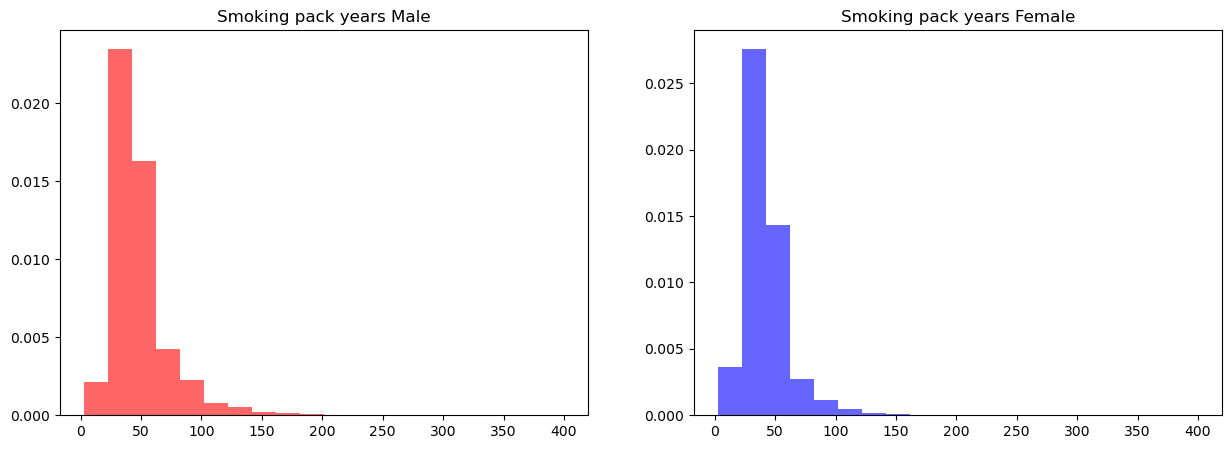

Group: White vs Group: black
H-statistic: 4189648.5, p-value: 7.774297204949516e-49


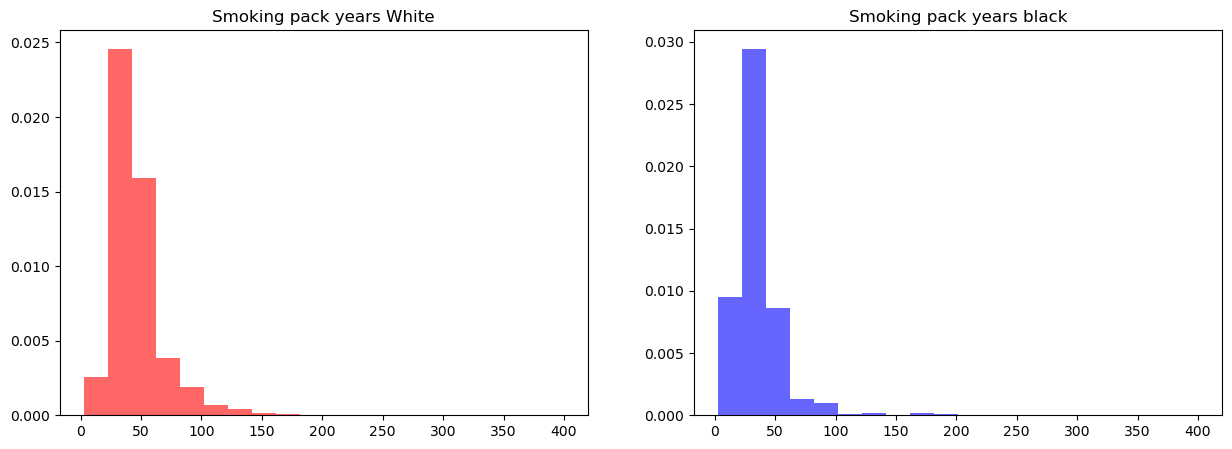

Group: White vs Group: asian
H-statistic: 4637663.0, p-value: 0.14716785317969644


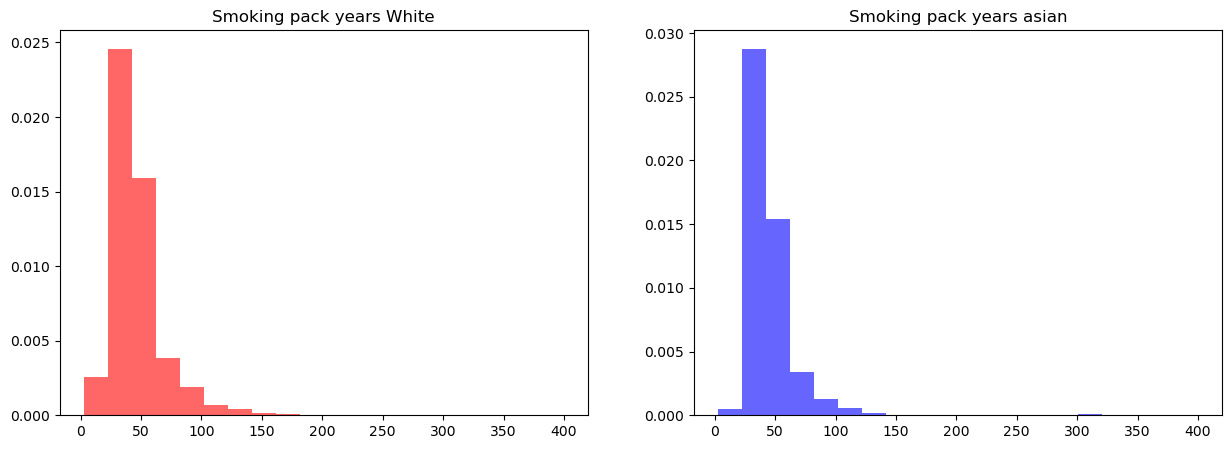

Group: White vs Group: mixed
H-statistic: 1747568.5, p-value: 2.11734362071363e-07


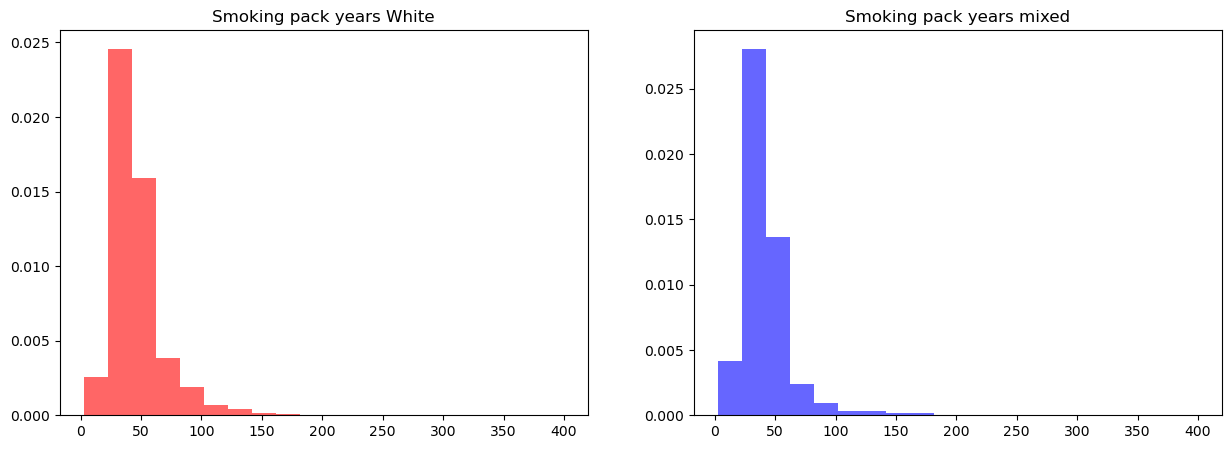

Group: White vs Group: other
H-statistic: 2557687.5, p-value: 0.032805548810046506


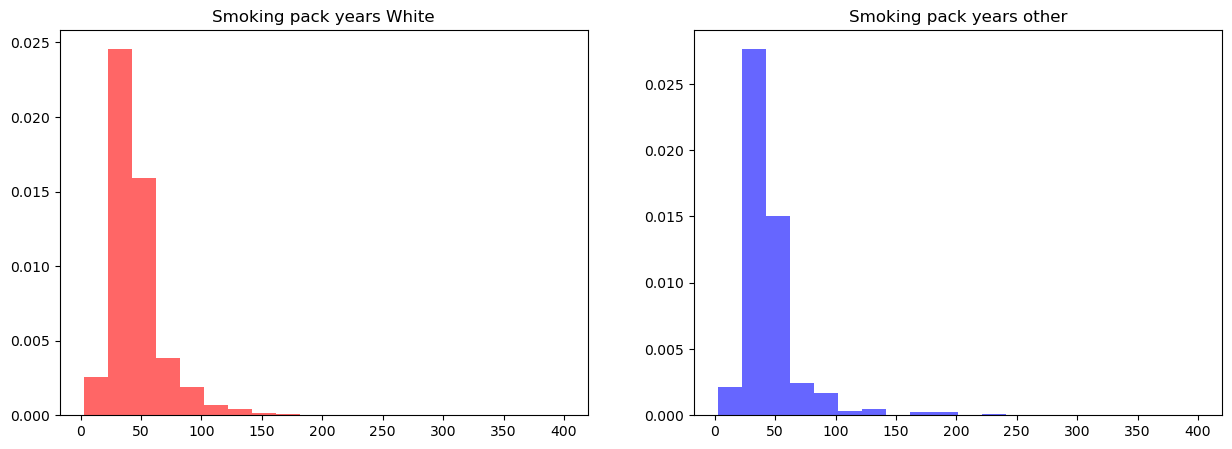

In [33]:

import scipy.stats as stats

protected_groups = {
    'gender' : {
        'male' : None,
        'female' : None
    },
    'ethnic_group' : {
        'white' : None,
        'black' : None,
        'asian' : None,
        'mixed' : None,
        'other' : None
    }
}

smoking_filter = (person_data['lung_health_check_clinical_smoking_pack_years']>-1)

protected_groups['gender']['male'] = person_data[(person_data['participant_details_gender']=='MALE')&smoking_filter]
protected_groups['gender']['female'] = person_data[(person_data['participant_details_gender']=='FEMALE')&smoking_filter]

protected_groups['ethnic_group']['white'] = person_data[(person_data['lung_health_check_demographics_race_ethnicgroup']=='White')&smoking_filter]
protected_groups['ethnic_group']['black'] = person_data[(person_data['lung_health_check_demographics_race_ethnicgroup']=='Black')&smoking_filter]
protected_groups['ethnic_group']['asian'] = person_data[(person_data['lung_health_check_demographics_race_ethnicgroup']=='Asian or Asian British')&smoking_filter]
protected_groups['ethnic_group']['mixed'] = person_data[(person_data['lung_health_check_demographics_race_ethnicgroup']=='Mixed')&smoking_filter]
protected_groups['ethnic_group']['other'] = person_data[(person_data['lung_health_check_demographics_race_ethnicgroup']=='Other ethnic groups')&smoking_filter]

group1 = protected_groups['gender']['male']['lung_health_check_clinical_smoking_pack_years']
group2 = protected_groups['gender']['female']['lung_health_check_clinical_smoking_pack_years']

stat, p_value = stats.mannwhitneyu(group1, group2)
print(f'Group: Male vs Group: Female')
print(f"H-statistic: {stat}, p-value: {p_value}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(group1, bins=master_bins, density=True, alpha=0.6, color='red')
ax[0].set_title('Smoking pack years Male')

ax[1].hist(group2, bins=master_bins, density=True, alpha=0.6, color='blue')
ax[1].set_title('Smoking pack years Female')
plt.show()


for group in ['black', 'asian', 'mixed', 'other']:
    
    group1 = protected_groups['ethnic_group']['white']['lung_health_check_clinical_smoking_pack_years']
    group2 = protected_groups['ethnic_group'][group]['lung_health_check_clinical_smoking_pack_years']

    stat, p_value = stats.mannwhitneyu(group1, group2)
    print(f'Group: White vs Group: {group}')
    print(f"H-statistic: {stat}, p-value: {p_value}")
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].hist(group1, bins=master_bins, density=True, alpha=0.6, color='red')
    ax[0].set_title('Smoking pack years White')

    ax[1].hist(group2, bins=master_bins, density=True, alpha=0.6, color='blue')
    ax[1].set_title(f'Smoking pack years {group}')
    plt.show()    

# Nodule Characteristics Comparison Across Protected Groups

In [7]:

filters = {
    'gender' : {
        'male' : nodule_data['participant_details_gender'] == 'MALE',
        'female' : nodule_data['participant_details_gender'] == 'FEMALE'
    },
    'ethnic_group' : {
        'white' : nodule_data['lung_health_check_demographics_race_ethnicgroup'] == 'White',
        'asian' : nodule_data['lung_health_check_demographics_race_ethnicgroup'] == 'Asian or Asian British',
        'black' : nodule_data['lung_health_check_demographics_race_ethnicgroup'] == 'Black'   
    },
    'nodule_type' : {
        'solid' : nodule_data['radiology_report_nodule_type'] == 'SOLID',
        'perifissural' : nodule_data['radiology_report_nodule_type'] == 'PERIFISSURAL',
        'part-solid' : nodule_data['radiology_report_nodule_type'] == 'PART_SOLID',
        'non-solid' : nodule_data['radiology_report_nodule_type'] == 'NON_SOLID',
        'consolidation' : nodule_data['radiology_report_nodule_type'] == 'CALCIFIED',
    }
}



data_male = nodule_data[filters['gender']['male']]
data_female = nodule_data[filters['gender']['female']]

data_white = nodule_data[filters['ethnic_group']['white']]
data_asian = nodule_data[filters['ethnic_group']['asian']]
data_black = nodule_data[filters['ethnic_group']['black']]


data = {}

for gender, gender_filter in filters['gender'].items():
    data[f'{gender}'] = nodule_data[gender_filter]

    for ethnic_group, ethnic_group_filter in filters['ethnic_group'].items():    
        data[f'{ethnic_group}'] = nodule_data[ethnic_group_filter]
        data[f'{gender}_{ethnic_group}'] = nodule_data[gender_filter&ethnic_group_filter]

        for nodule_type, nodule_type_filter in filters['nodule_type'].items():

            data[f'{gender}_{nodule_type}'] = nodule_data[gender_filter&nodule_type_filter]
            data[f'{gender}_{ethnic_group}_{nodule_type}'] = nodule_data[gender_filter&ethnic_group_filter&nodule_type_filter]

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.9991059813880334


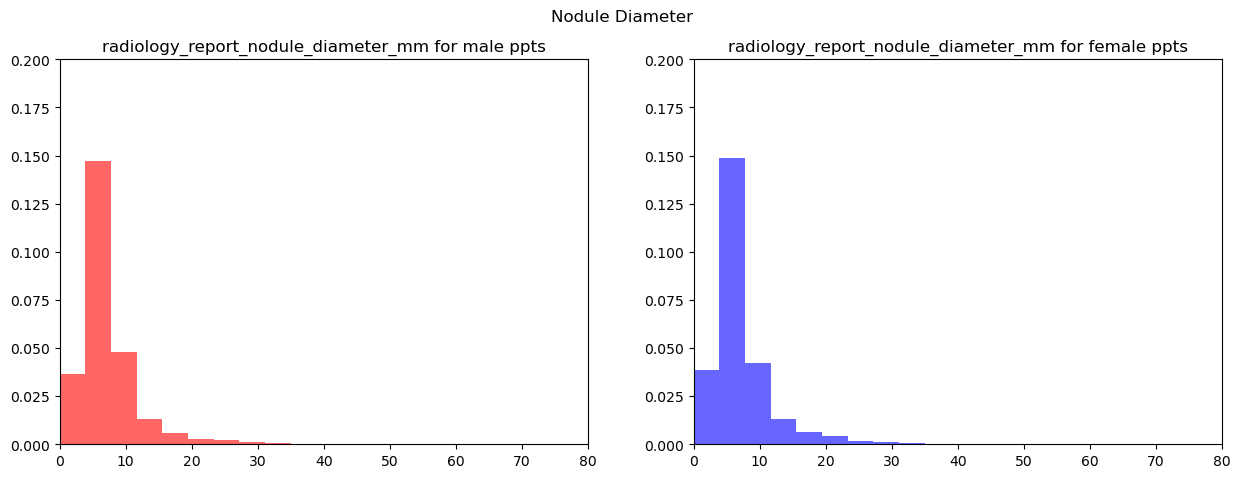

Chi-square test for radiology_report_nodule_site between male and female
Chi2: 13.50484901722066
p-value: 0.01908027431905089
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_site_male,radiology_report_nodule_site_female
LEFT_LOWER_LOBE,1765.619503,1256.380497
LEFT_UPPER_LOBE,1620.724190,1153.275810
NOT_ANSWERED,1996.400345,1420.599655
RIGHT_LOWER_LOBE,1907.593540,1357.406460
RIGHT_MIDDLE_LOBE,936.561239,666.438761
RIGHT_UPPER_LOBE,2282.101184,1623.898816


LEFT_LOWER_LOBE      0.013362
LEFT_UPPER_LOBE     -0.000395
NOT_ANSWERED         0.003342
RIGHT_LOWER_LOBE    -0.001738
RIGHT_MIDDLE_LOBE    0.004678
RIGHT_UPPER_LOBE    -0.019249
dtype: float64

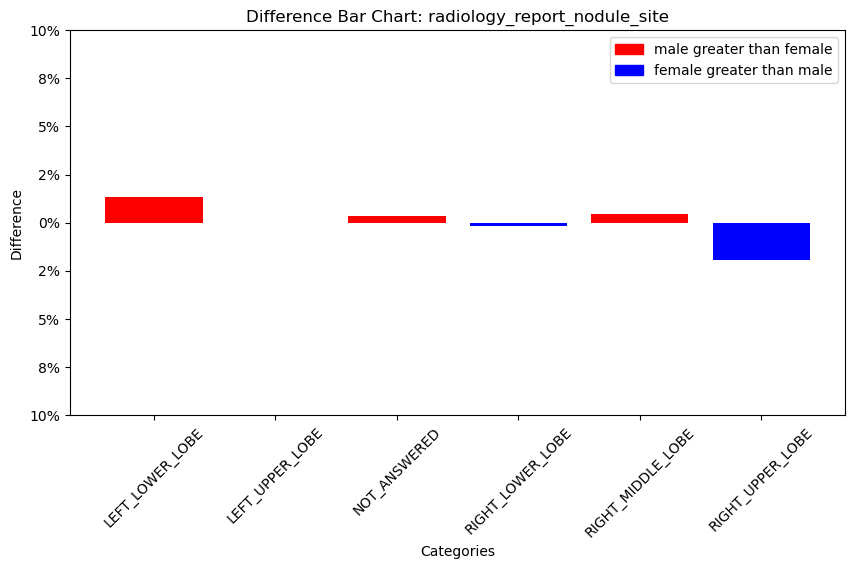

Chi-square test for radiology_report_nodule_type between male and female
Chi2: 105.61521510373508
p-value: 3.456469036415487e-21
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_type_male,radiology_report_nodule_type_female
CALCIFIED,496.617001,353.382999
ENDOBRONCHIAL,82.379997,58.620003
NON_SOLID,631.579974,449.420026
PART_SOLID,311.408072,221.591928
PERIFISSURAL,4633.144493,3296.855507
SOLID,4353.870462,3098.129538


CALCIFIED       -0.011585
ENDOBRONCHIAL   -0.001689
NON_SOLID       -0.028056
PART_SOLID      -0.010622
PERIFISSURAL     0.040708
SOLID            0.011245
dtype: float64

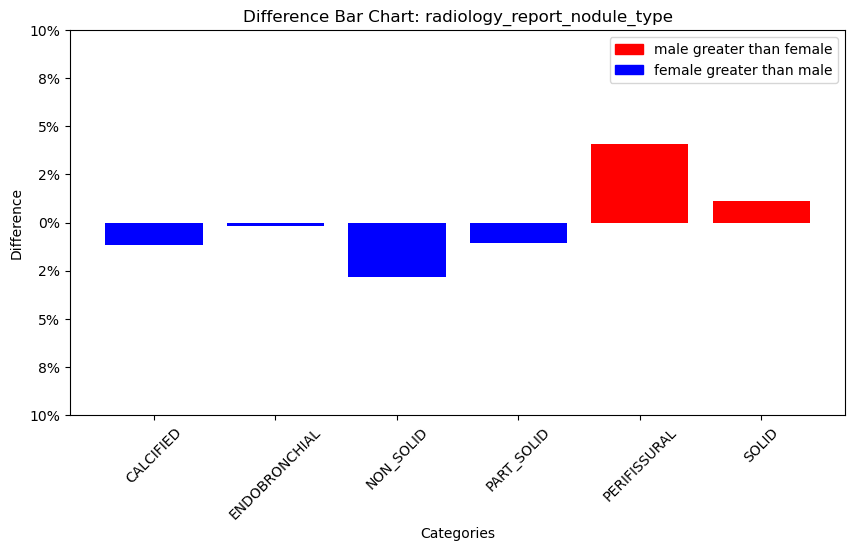

Chi-square test for radiology_report_management_plan between male and female
Chi2: 62.605276672454366
p-value: 1.6310242310824089e-13
Degrees of freedom: 3
Expected frequencies table:


,radiology_report_management_plan_male,radiology_report_management_plan_female
3_MONTH_FOLLOW_UP_SCAN,2009.253961,1429.746039
ALWAYS_SCAN_AT_YEAR_1,592.434870,421.565130
RANDOMISATION_AT_YEAR_1,7623.947351,5425.052649
URGENT_REFERRAL,283.363818,201.636182


3_MONTH_FOLLOW_UP_SCAN     0.005206
ALWAYS_SCAN_AT_YEAR_1     -0.025048
RANDOMISATION_AT_YEAR_1    0.027249
URGENT_REFERRAL           -0.007407
dtype: float64

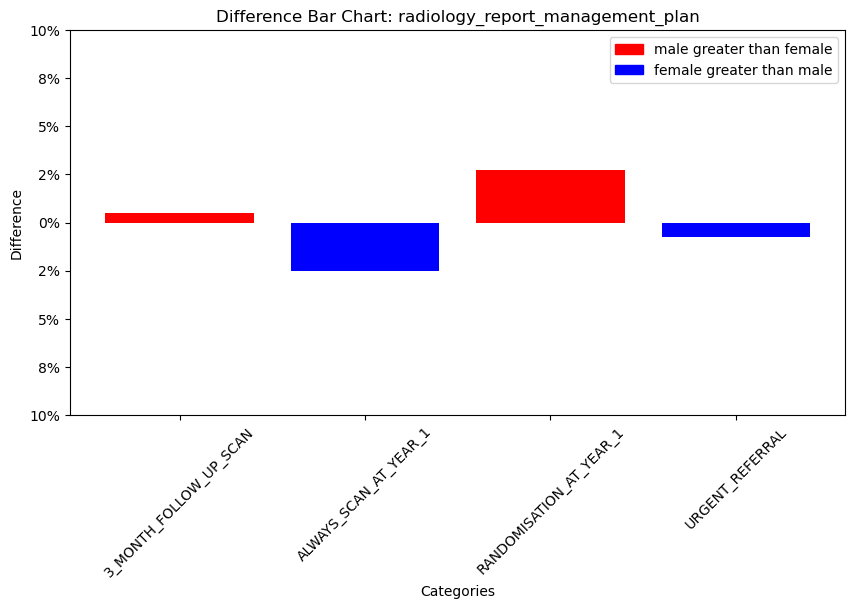

In [8]:
_, master_bins = np.histogram(nodule_data['radiology_report_nodule_diameter_mm'], bins=20, density=True)

hist_comparison(data_male, 'male', data_female, 'female', master_bins, 'Nodule Diameter', 'radiology_report_nodule_diameter_mm')

for variable, name in categorical_dict.items():
    _, _, _, _ = chi_square_test(data_male, 'male', data_female, 'female', variable)
    differences_bar_chart(data_male, 'male', data_female, 'female', variable, name)

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.998392201939949


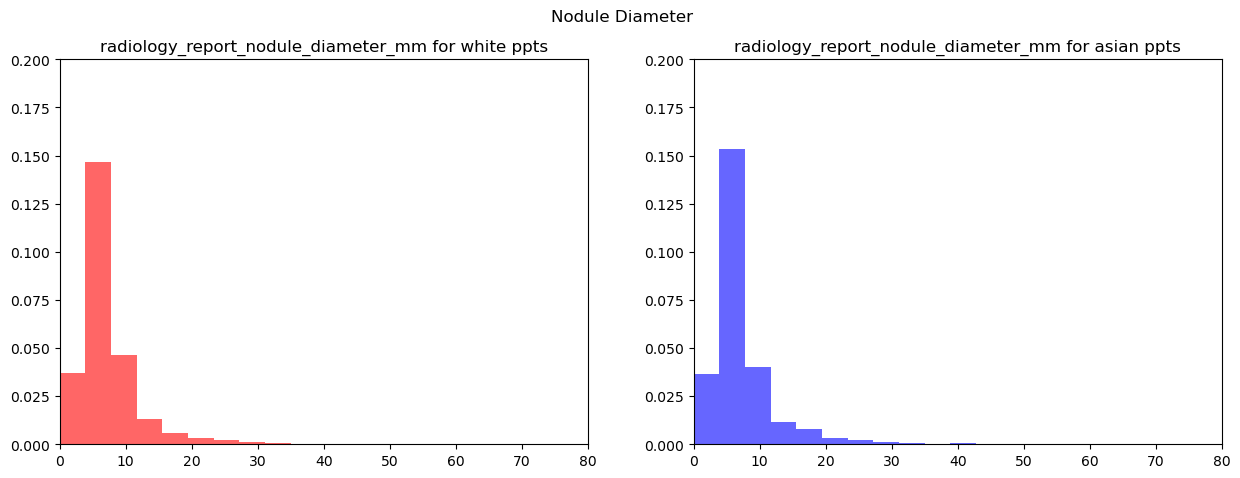

Chi-square test for radiology_report_nodule_site between white and asian
Chi2: 18.350747940284982
p-value: 0.002537469420646142
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_site_white,radiology_report_nodule_site_asian
LEFT_LOWER_LOBE,2563.228998,175.771002
LEFT_UPPER_LOBE,2341.438099,160.561901
NOT_ANSWERED,2880.474208,197.525792
RIGHT_LOWER_LOBE,2777.533284,190.466716
RIGHT_MIDDLE_LOBE,1349.461926,92.538074
RIGHT_UPPER_LOBE,3326.863486,228.136514


LEFT_LOWER_LOBE      0.032488
LEFT_UPPER_LOBE     -0.006583
NOT_ANSWERED        -0.034229
RIGHT_LOWER_LOBE     0.016838
RIGHT_MIDDLE_LOBE    0.013843
RIGHT_UPPER_LOBE    -0.022357
dtype: float64

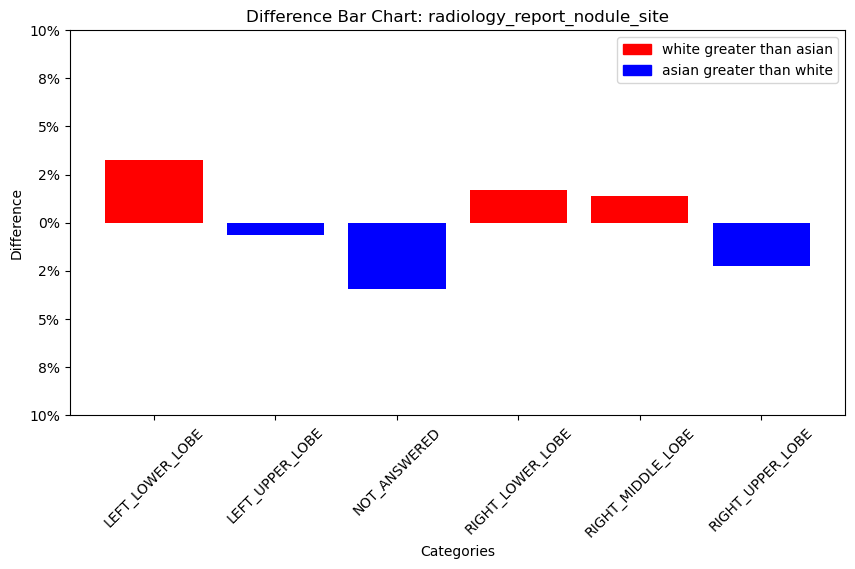

Chi-square test for radiology_report_nodule_type between white and asian
Chi2: 11.275889495388771
p-value: 0.04617613387426958
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_type_white,radiology_report_nodule_type_asian
CALCIFIED,740.238823,50.761177
ENDOBRONCHIAL,122.593282,8.406718
NON_SOLID,930.211619,63.788381
PART_SOLID,458.555023,31.444977
PERIFISSURAL,6724.849791,461.150209
SOLID,6262.551462,429.448538


CALCIFIED       -0.008425
ENDOBRONCHIAL   -0.001629
NON_SOLID        0.001829
PART_SOLID       0.000455
PERIFISSURAL     0.049236
SOLID           -0.041466
dtype: float64

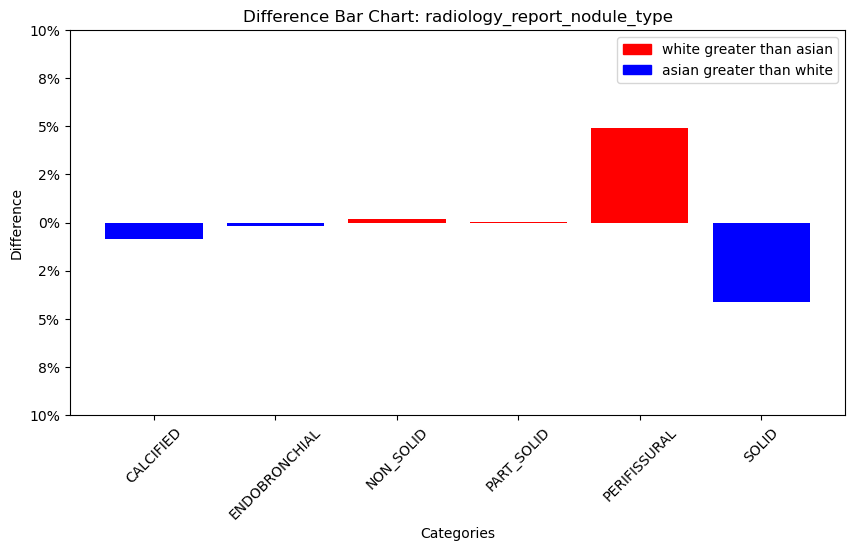

Chi-square test for radiology_report_management_plan between white and asian
Chi2: 2.883216452713074
p-value: 0.40998356868404395
Degrees of freedom: 3
Expected frequencies table:


,radiology_report_management_plan_white,radiology_report_management_plan_asian
3_MONTH_FOLLOW_UP_SCAN,2937.559629,201.440371
ALWAYS_SCAN_AT_YEAR_1,878.741157,60.258843
RANDOMISATION_AT_YEAR_1,11001.577254,754.422746
URGENT_REFERRAL,421.121960,28.878040


3_MONTH_FOLLOW_UP_SCAN    -0.017956
ALWAYS_SCAN_AT_YEAR_1      0.001287
RANDOMISATION_AT_YEAR_1    0.020883
URGENT_REFERRAL           -0.004215
dtype: float64

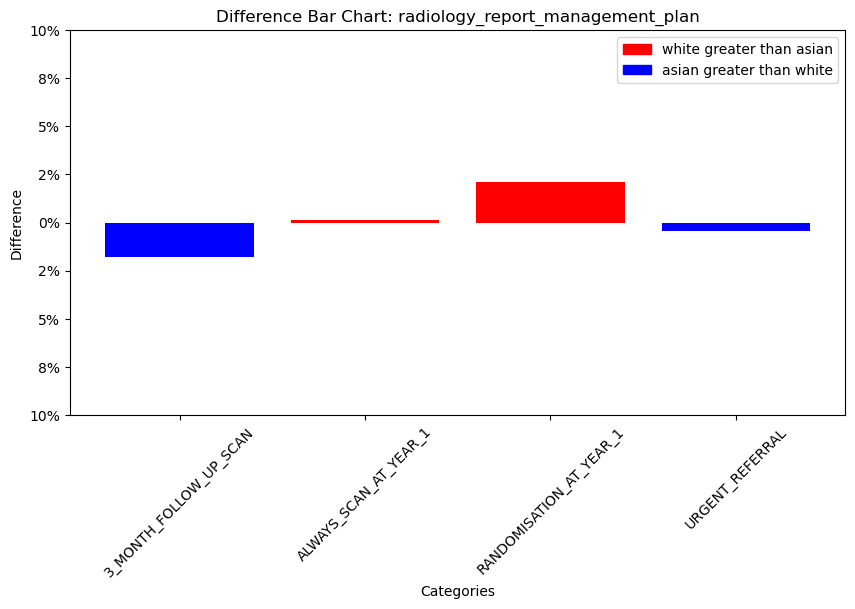

In [9]:
# Is Nodule Size the key driver ... compare histograms

_, master_bins = np.histogram(nodule_data['radiology_report_nodule_diameter_mm'], bins=20, density=True)

hist_comparison(data['white'], 'white', data['asian'], 'asian', master_bins, 'Nodule Diameter', 'radiology_report_nodule_diameter_mm')

for key, value in categorical_dict.items():
    _, _, _, _ = chi_square_test(data['white'], 'white', data['asian'], 'asian', key)
    differences_bar_chart(data['white'], 'white', data['asian'], 'asian', key, value)

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.9976259383148143


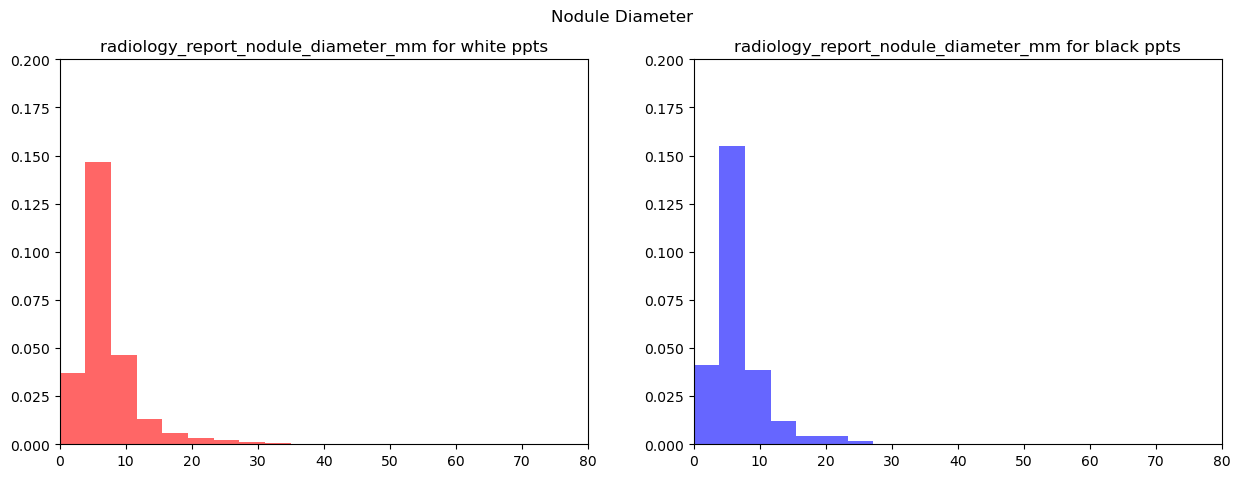

Chi-square test for radiology_report_nodule_site between white and black
Chi2: 14.79917175987701
p-value: 0.011255812834764201
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_site_white,radiology_report_nodule_site_black
LEFT_LOWER_LOBE,2573.871681,123.128319
LEFT_UPPER_LOBE,2352.463364,112.536636
NOT_ANSWERED,2873.536385,137.463615
RIGHT_LOWER_LOBE,2780.010458,132.989542
RIGHT_MIDDLE_LOBE,1366.623747,65.376253
RIGHT_UPPER_LOBE,3292.494364,157.505636


LEFT_LOWER_LOBE      0.030369
LEFT_UPPER_LOBE     -0.025101
NOT_ANSWERED        -0.038142
RIGHT_LOWER_LOBE     0.020108
RIGHT_MIDDLE_LOBE   -0.005209
RIGHT_UPPER_LOBE     0.017975
dtype: float64

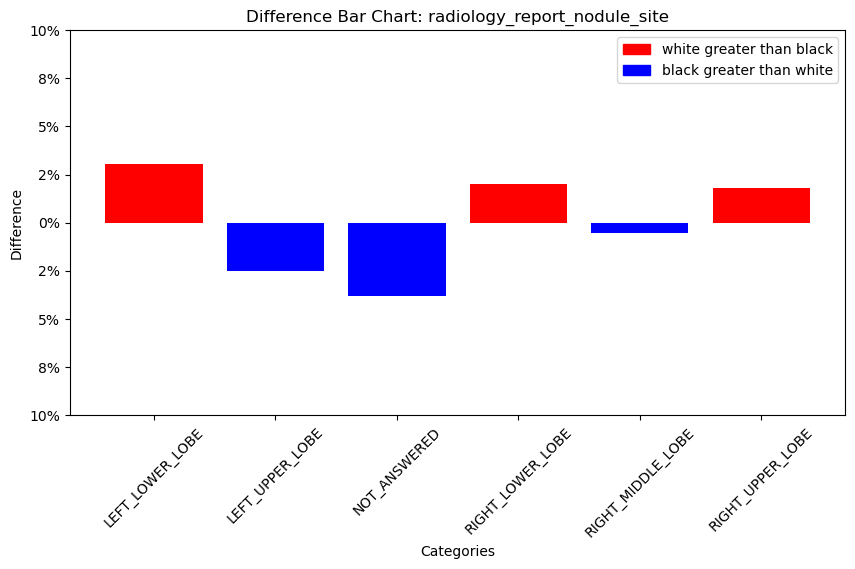

Chi-square test for radiology_report_nodule_type between white and black
Chi2: 12.025401691102175
p-value: 0.03444137155064003
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_type_white,radiology_report_nodule_type_black
CALCIFIED,726.257452,34.742548
ENDOBRONCHIAL,117.384582,5.615418
NON_SOLID,918.081037,43.918963
PART_SOLID,452.360095,21.639905
PERIFISSURAL,6781.584043,324.415957
SOLID,6243.332791,298.667209


CALCIFIED        0.008254
ENDOBRONCHIAL    0.005197
NON_SOLID        0.020007
PART_SOLID       0.009544
PERIFISSURAL    -0.012338
SOLID           -0.030663
dtype: float64

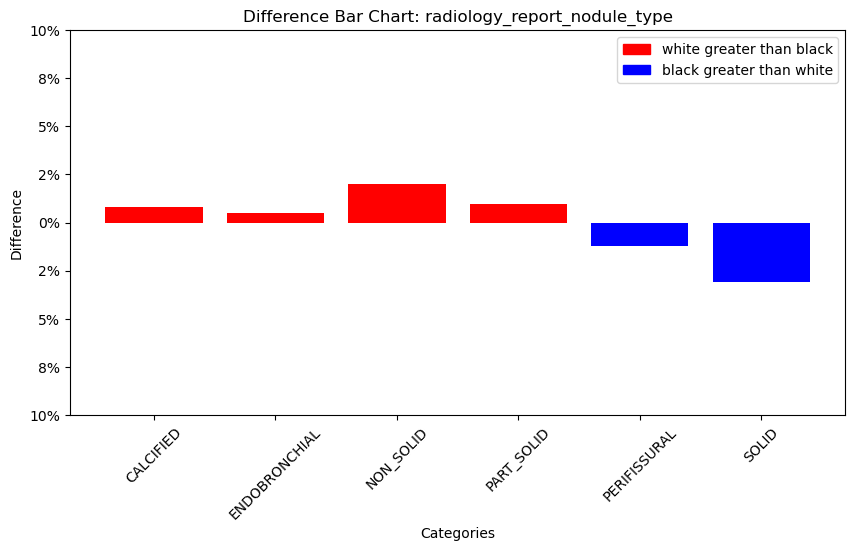

Chi-square test for radiology_report_management_plan between white and black
Chi2: 11.9031816403322
p-value: 0.007722286191081473
Degrees of freedom: 3
Expected frequencies table:


,radiology_report_management_plan_white,radiology_report_management_plan_black
3_MONTH_FOLLOW_UP_SCAN,2902.166771,138.833229
ALWAYS_SCAN_AT_YEAR_1,863.683304,41.316696
RANDOMISATION_AT_YEAR_1,11058.009331,528.990669
URGENT_REFERRAL,415.140594,19.859406


3_MONTH_FOLLOW_UP_SCAN     0.025633
ALWAYS_SCAN_AT_YEAR_1      0.023453
RANDOMISATION_AT_YEAR_1   -0.051758
URGENT_REFERRAL            0.002673
dtype: float64

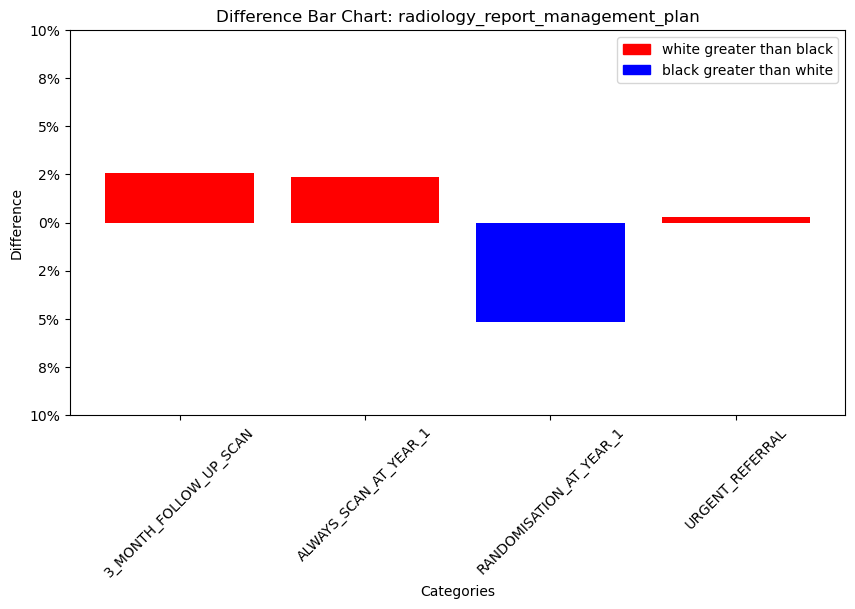

In [10]:
hist_comparison(data_white, 'white', data_black, 'black', master_bins, 'Nodule Diameter', 'radiology_report_nodule_diameter_mm')
for key, value in categorical_dict.items():
    _, _, _, _ = chi_square_test(data_white, 'white', data_black, 'black', key)
    differences_bar_chart(data_white, 'white', data_black, 'black', key, value)

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.9992861616249475


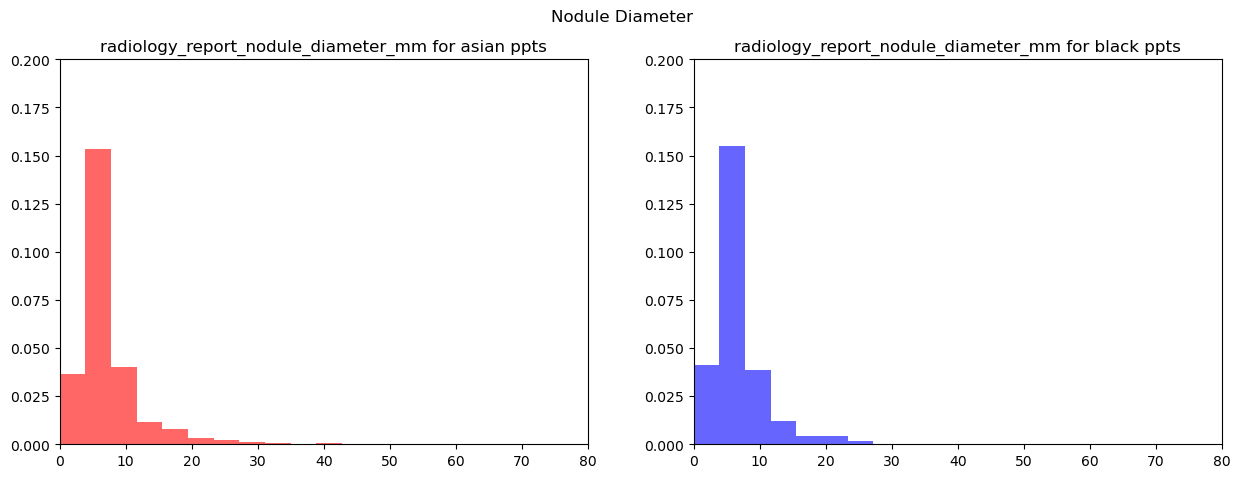

Chi-square test for radiology_report_nodule_site between asian and black
Chi2: 5.95639829037582
p-value: 0.31048470512359905
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_site_asian,radiology_report_nodule_site_black
LEFT_LOWER_LOBE,144.909808,101.090192
LEFT_UPPER_LOBE,174.952086,122.047914
NOT_ANSWERED,232.680383,162.319617
RIGHT_LOWER_LOBE,172.595829,120.404171
RIGHT_MIDDLE_LOBE,87.181511,60.818489
RIGHT_UPPER_LOBE,232.680383,162.319617


LEFT_LOWER_LOBE     -0.002119
LEFT_UPPER_LOBE     -0.018518
NOT_ANSWERED        -0.003913
RIGHT_LOWER_LOBE     0.003270
RIGHT_MIDDLE_LOBE   -0.019052
RIGHT_UPPER_LOBE     0.040332
dtype: float64

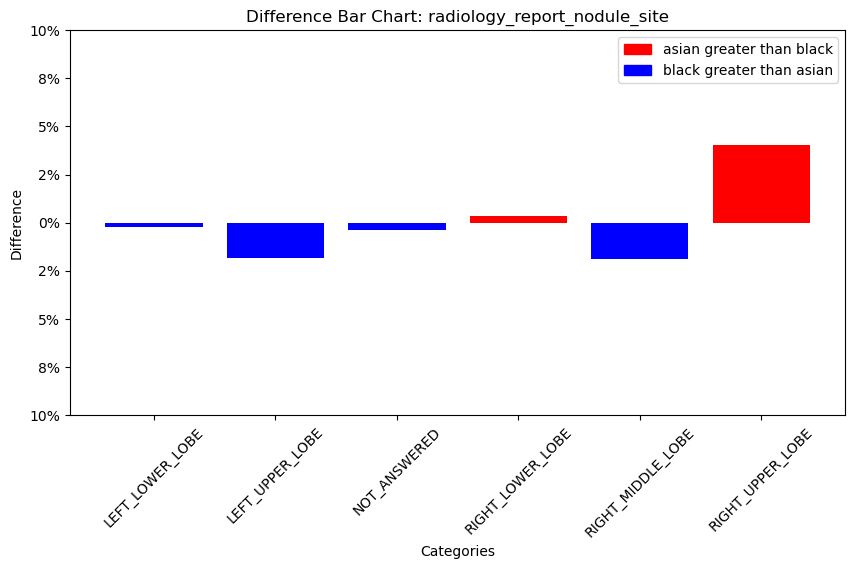

Chi-square test for radiology_report_nodule_type between asian and black
Chi2: 13.45465931691768
p-value: 0.019470972560833487
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_type_asian,radiology_report_nodule_type_black
CALCIFIED,51.837655,36.162345
ENDOBRONCHIAL,7.068771,4.931229
NON_SOLID,54.193912,37.806088
PART_SOLID,27.096956,18.903044
PERIFISSURAL,439.441939,306.558061
SOLID,465.360767,324.639233


CALCIFIED        0.016679
ENDOBRONCHIAL    0.006826
NON_SOLID        0.018178
PART_SOLID       0.009089
PERIFISSURAL    -0.061575
SOLID            0.010803
dtype: float64

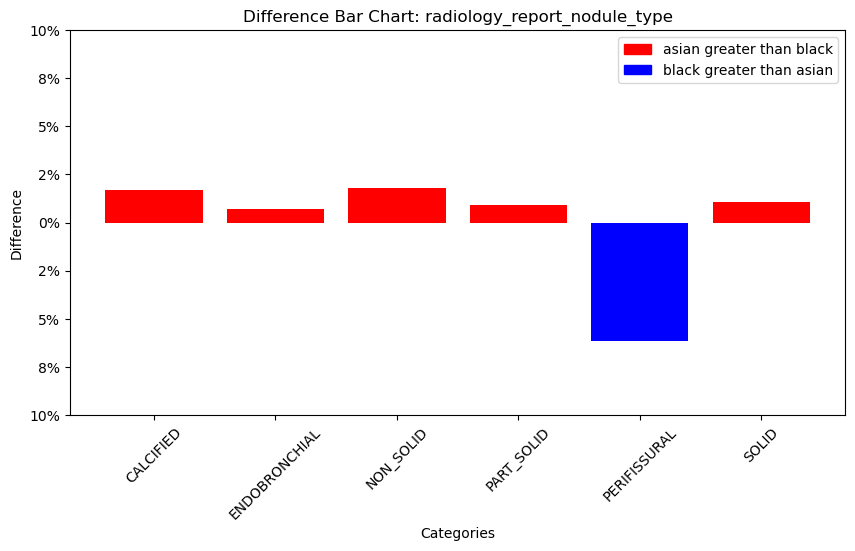

Chi-square test for radiology_report_management_plan between asian and black
Chi2: 12.516162980029748
p-value: 0.00580881634357435
Degrees of freedom: 3
Expected frequencies table:


,radiology_report_management_plan_asian,radiology_report_management_plan_black
3_MONTH_FOLLOW_UP_SCAN,200.281849,139.718151
ALWAYS_SCAN_AT_YEAR_1,49.481398,34.518602
RANDOMISATION_AT_YEAR_1,765.194476,533.805524
URGENT_REFERRAL,30.042277,20.957723


3_MONTH_FOLLOW_UP_SCAN     0.043589
ALWAYS_SCAN_AT_YEAR_1      0.022166
RANDOMISATION_AT_YEAR_1   -0.072642
URGENT_REFERRAL            0.006888
dtype: float64

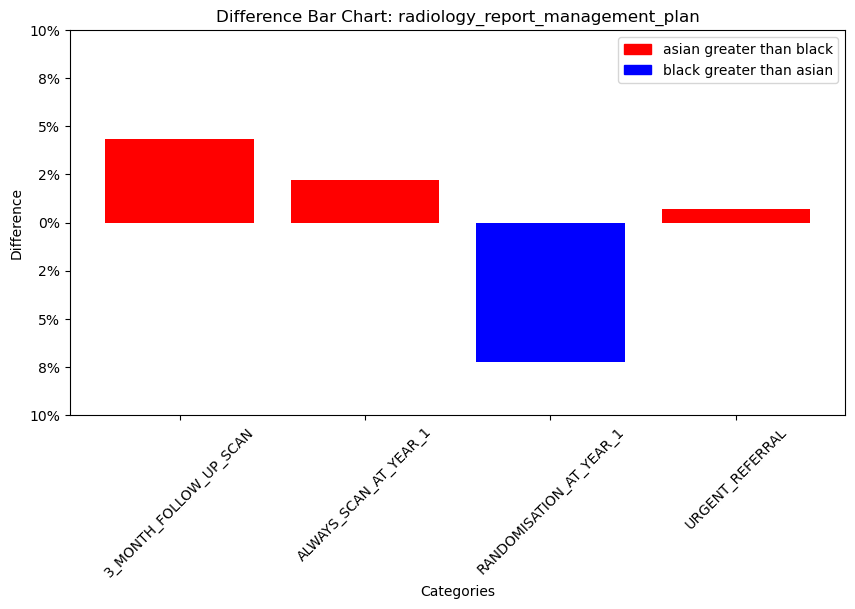

In [11]:
hist_comparison(data_asian, 'asian', data_black, 'black', master_bins, 'Nodule Diameter', 'radiology_report_nodule_diameter_mm')
for key, value in categorical_dict.items():
    _, _, _, _ = chi_square_test(data_asian, 'asian', data_black, 'black', key)
    differences_bar_chart(data_asian, 'asian', data_black, 'black', key, value)

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.9863217215221176


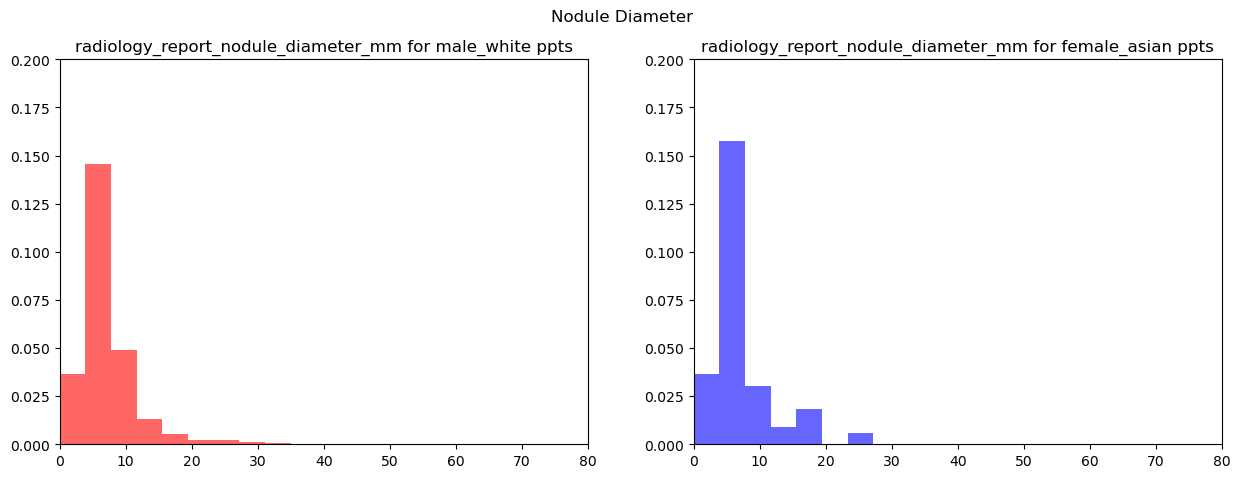

Chi-square test for radiology_report_nodule_site between male_white and female_asian
Chi2: 7.9581356914040065
p-value: 0.15855799399698334
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_site_male_white,radiology_report_nodule_site_female_asian
LEFT_LOWER_LOBE,1510.775822,15.224178
LEFT_UPPER_LOBE,1280.100352,12.899648
NOT_ANSWERED,1583.047535,15.952465
RIGHT_LOWER_LOBE,1544.436620,15.563380
RIGHT_MIDDLE_LOBE,777.168427,7.831573
RIGHT_UPPER_LOBE,1739.471244,17.528756


LEFT_LOWER_LOBE      0.026430
LEFT_UPPER_LOBE     -0.001193
NOT_ANSWERED        -0.024331
RIGHT_LOWER_LOBE     0.077994
RIGHT_MIDDLE_LOBE    0.021765
RIGHT_UPPER_LOBE    -0.100666
dtype: float64

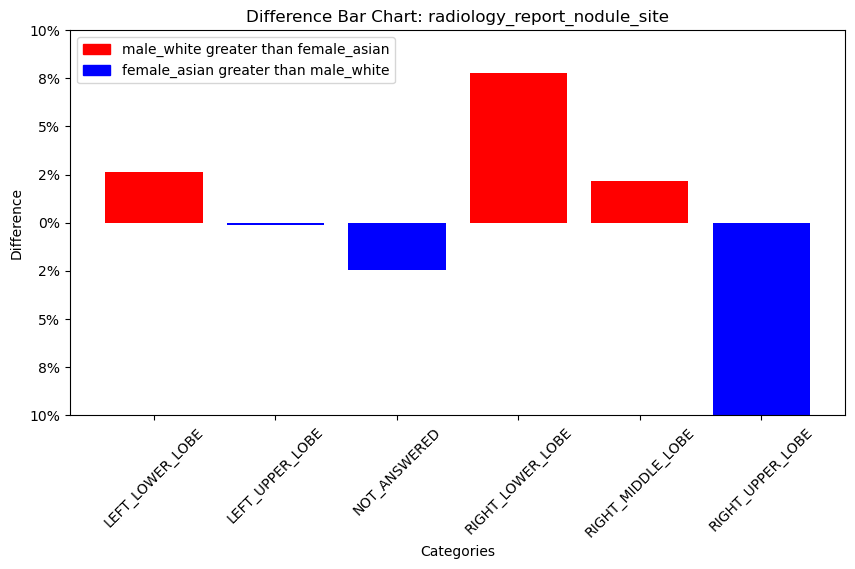

Chi-square test for radiology_report_nodule_type between male_white and female_asian
Chi2: 7.480251386686295
p-value: 0.18730216250475343
Degrees of freedom: 5
Expected frequencies table:


,radiology_report_nodule_type_male_white,radiology_report_nodule_type_female_asian
CALCIFIED,355.418427,3.581573
ENDOBRONCHIAL,56.431338,0.568662
NON_SOLID,405.909624,4.090376
PART_SOLID,211.865023,2.134977
PERIFISSURAL,3917.522887,39.477113
SOLID,3487.852700,35.147300


CALCIFIED       -0.004972
ENDOBRONCHIAL    0.006758
NON_SOLID       -0.058342
PART_SOLID      -0.010279
PERIFISSURAL     0.017553
SOLID            0.049283
dtype: float64

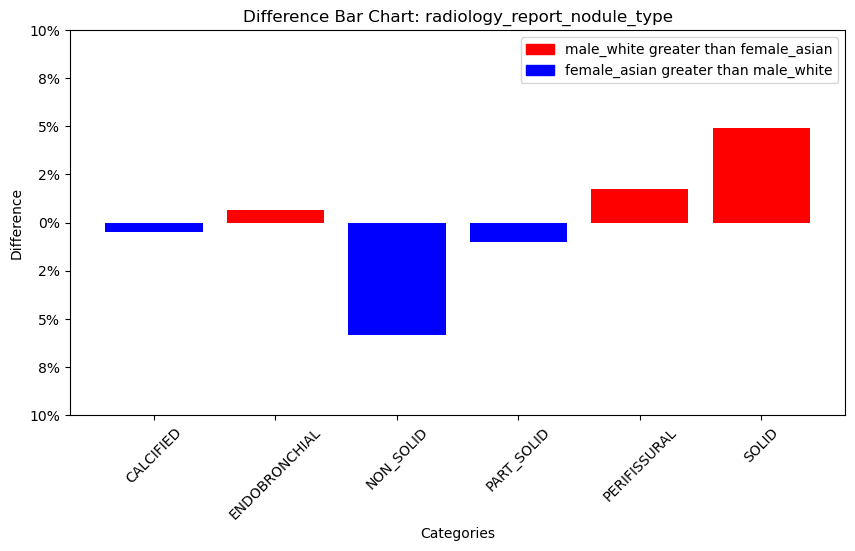

Chi-square test for radiology_report_management_plan between male_white and female_asian
Chi2: 8.728199075199118
p-value: 0.03313165437526616
Degrees of freedom: 3
Expected frequencies table:


,radiology_report_management_plan_male_white,radiology_report_management_plan_female_asian
3_MONTH_FOLLOW_UP_SCAN,1622.648474,16.351526
ALWAYS_SCAN_AT_YEAR_1,388.089202,3.910798
RANDOMISATION_AT_YEAR_1,6222.297535,62.702465
URGENT_REFERRAL,201.964789,2.035211


3_MONTH_FOLLOW_UP_SCAN     0.075477
ALWAYS_SCAN_AT_YEAR_1     -0.048593
RANDOMISATION_AT_YEAR_1   -0.003536
URGENT_REFERRAL           -0.023348
dtype: float64

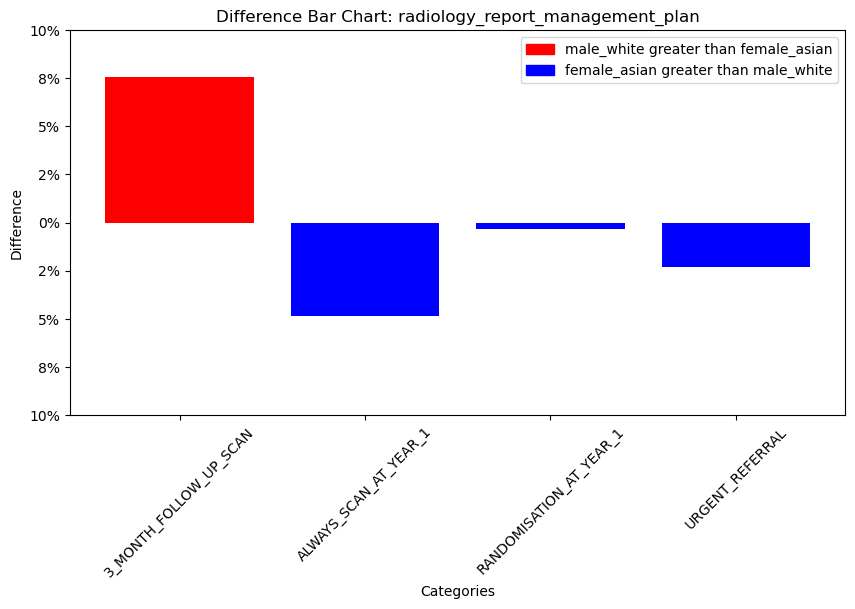

In [12]:
_, master_bins = np.histogram(nodule_data['radiology_report_nodule_diameter_mm'], bins=20, density=True)

hist_comparison(data['male_white'], 'male_white', data['female_asian'], 'female_asian', master_bins, 'Nodule Diameter', 'radiology_report_nodule_diameter_mm')
for key, value in categorical_dict.items():
    _, _, _, _ = chi_square_test(data['male_white'], 'male_white', data['female_asian'], 'female_asian', key)
    differences_bar_chart(data['male_white'], 'male_white', data['female_asian'], 'female_asian', key, value)

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.995619528683179


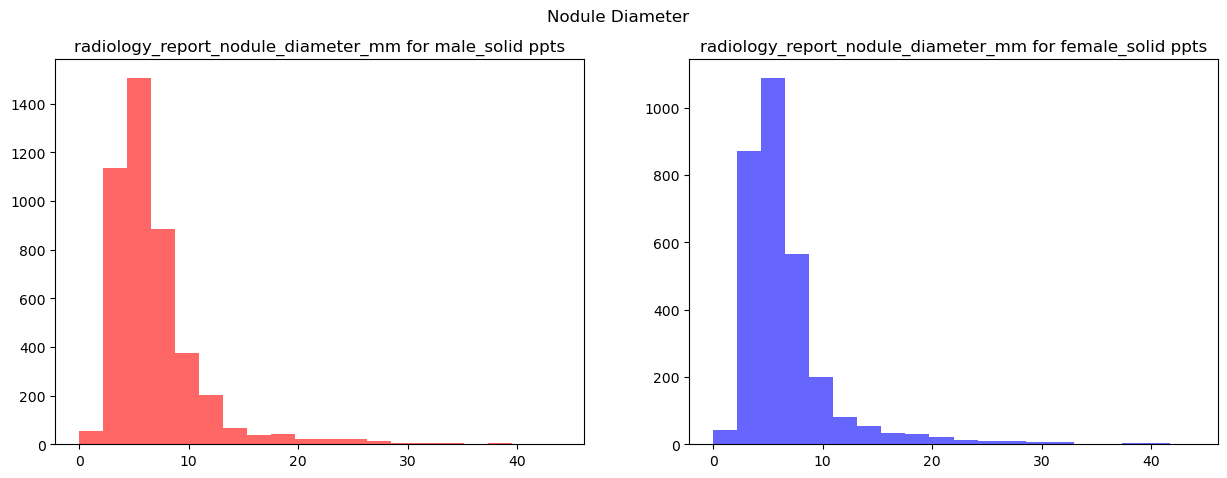

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.9964975636026764


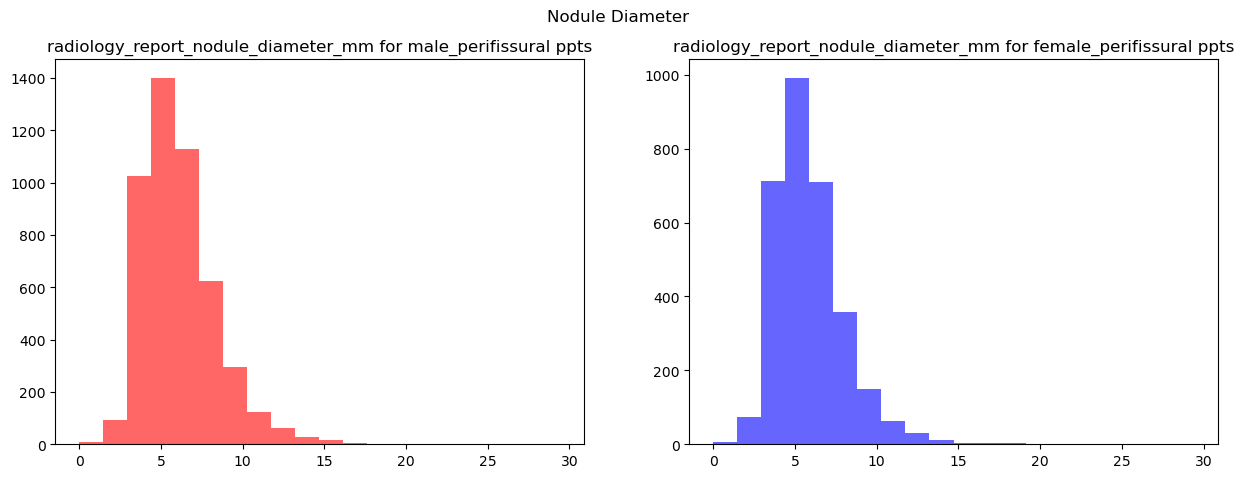

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.9572517539059614


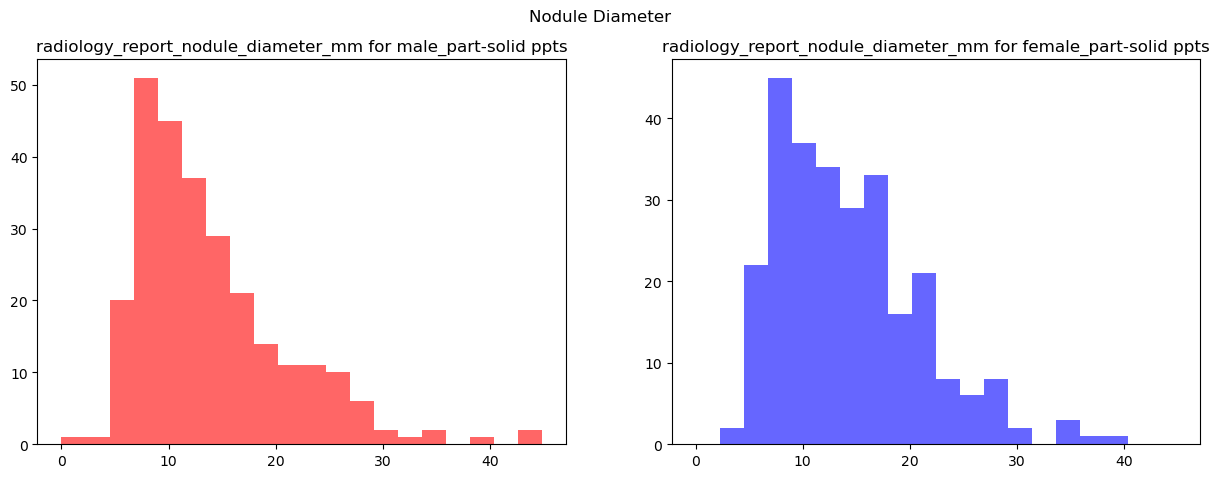

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.9704996965463029


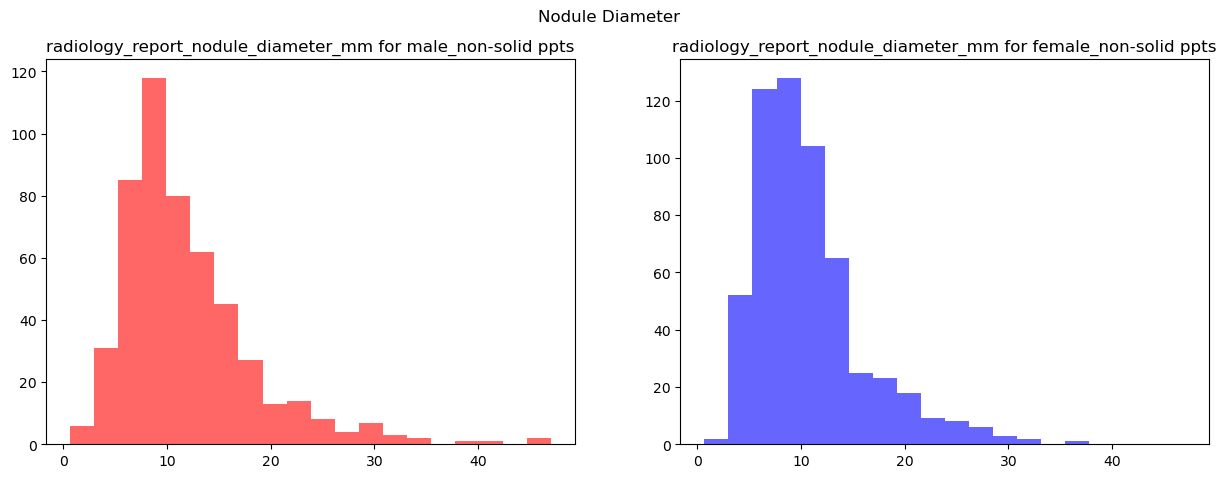

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.9484265125033882


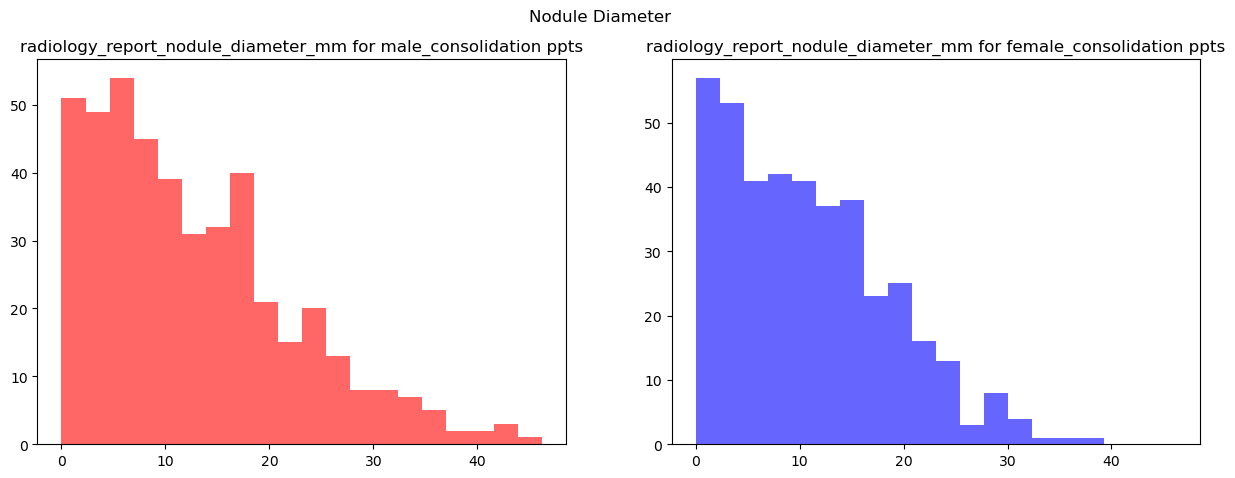

In [13]:

density = False

for nodule_type in filters['nodule_type'].keys():

    _, master_bins = np.histogram(data[f'male_{nodule_type}']['radiology_report_nodule_diameter_mm'], bins=20, density=density)
    hist_comparison(data[f'male_{nodule_type}'], f'male_{nodule_type}', data[f'female_{nodule_type}'], f'female_{nodule_type}', master_bins, 'Nodule Diameter', 'radiology_report_nodule_diameter_mm', density=density)


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [15]:
from cv2 import norm


solid_reliable = (nodule_data.radiology_report_nodule_size_volume_cub_mm < 40)&(nodule_data.radiology_report_nodule_type=='SOLID')&~(nodule_data.radiology_report_nodule_reliable_segment.str.lower().str.startswith('u'))
solid_unreliable = (nodule_data.radiology_report_nodule_diameter_mm < 4)&(nodule_data.radiology_report_nodule_type=='SOLID')&(nodule_data.radiology_report_nodule_reliable_segment.str.lower().str.startswith('u'))
non_solid_small = (nodule_data.radiology_report_nodule_diameter_mm < 4)&(nodule_data.radiology_report_nodule_type=='NON_SOLID')

nodule_data = nodule_data[~(solid_reliable|solid_unreliable|non_solid_small)]
nodule_data = nodule_data[~nodule_data.participant_id.isin(['summit-9754-pkv','summit-2625-nvf','summit-6242-zvz'])]
nodule_data = nodule_data[nodule_data.radiology_report_nodule_type!='ENDOBRONCHIAL']

def set_site_cat(s):
    if s.lower().find('upper') > -1:
        return '1.upper'
    
    elif s.lower().find('not') > -1:
        return '9.na'
    else:
        return '2.middle_lower'

diameter_cats = [0, 4, 8, 15, 20, 30, 40, 999]
nodule_data['diameter_cats'] = pd.cut(
    nodule_data['radiology_report_nodule_diameter_mm'], 
    bins=diameter_cats,
    labels=[f'{diameter_cats[i]:02}-{diameter_cats[i+1]:02}' for i in range(len(diameter_cats))[:-1]]
)

nodule_data['nodule_site_cat'] = nodule_data['radiology_report_nodule_site'].apply(set_site_cat)


display(
    pd.crosstab(
        [
            nodule_data['radiology_report_nodule_type']
        ],
        [
            nodule_data['participant_details_gender'],
            nodule_data['lung_health_check_demographics_race_ethnicgroup']
        ],
        normalize='columns'
    ).applymap(lambda x: f'{round(x * 100,1)}%')
)

pd.crosstab(
    nodule_data['nodule_site_cat'],
    [
        nodule_data['diameter_cats'],
        nodule_data['radiology_report_nodule_type']
    ],
    normalize='all',
    margins=True
).T.applymap(lambda x: f'{round(x * 100,1)}%')

display(pd.crosstab(
    nodule_data['radiology_report_nodule_type'],
    [
        nodule_data['diameter_cats'],
        
    ],
    normalize='index',
    margins=True
).T.applymap(lambda x: f'{round(x * 100,1)}%'))

display(pd.crosstab(
    nodule_data['nodule_site_cat'],
    [
        nodule_data['diameter_cats'],
        nodule_data['radiology_report_nodule_type']
    ],
    normalize='all',
    margins=True
).T.applymap(lambda x: f'{round(x * 100,1)}%'))

participant_details_gender                                      FEMALE         \
lung_health_check_demographics_race_ethnicgroup Asian or Asian British  Black   
radiology_report_nodule_type                                                    
CALCIFIED                                                         5.9%   5.5%   
NON_SOLID                                                        13.2%   4.5%   
PART_SOLID                                                        4.4%   3.5%   
PERIFISSURAL                                                     55.9%  51.5%   
SOLID                                                            20.6%  35.0%   

participant_details_gender                                                  \
lung_health_check_demographics_race_ethnicgroup  Mixed Other ethnic groups   
radiology_report_nodule_type                                                 
CALCIFIED                                         4.5%                6.2%   
NON_SOLID                                         8.2%               11.5%   
PART_SOLID                                        5.2%                3.1%   
PERIFISSURAL                                     54.5%               53.1%   
SOLID                                            27.6%               26.0%   

participant_details_gender                                               MALE  \
lung_health_check_demographics_race_ethnicgroup  White Asian or Asian British   
radiology_report_nodule_type                                                    
CALCIFIED                                         6.9%                   7.3%   
NON_SOLID                                         9.5%                   7.1%   
PART_SOLID                                        4.6%                   3.7%   
PERIFISSURAL                                     52.4%                  49.7%   
SOLID                                            26.7%                  32.1%   

participant_details_gender                                     \
lung_health_check_demographics_race_ethnicgroup  Black  Mixed   
radiology_report_nodule_type                                    
CALCIFIED                                         4.9%   5.0%   
NON_SOLID                                         5.7%   7.5%   
PART_SOLID                                        2.2%   2.5%   
PERIFISSURAL                                     62.2%  52.8%   
SOLID                                            25.1%  32.1%   

participant_details_gender                                                  
lung_health_check_demographics_race_ethnicgroup Other ethnic groups  White  
radiology_report_nodule_type                                                
CALCIFIED                                                      2.7%   5.2%  
NON_SOLID                                                      5.8%   5.7%  
PART_SOLID                                                     3.8%   3.1%  
PERIFISSURAL                                                  55.8%  57.1%  
SOLID                                                         31.9%  28.9%

radiology_report_nodule_type,CALCIFIED,NON_SOLID,PART_SOLID,PERIFISSURAL,SOLID,All
diameter_cats,,,,,,
00-04,17.9%,0.5%,0.2%,15.9%,0.2%,9.9%
04-08,20.6%,30.7%,19.0%,68.5%,59.5%,58.6%
08-15,28.3%,49.5%,44.2%,15.2%,32.3%,24.4%
15-20,15.9%,10.5%,18.4%,0.3%,3.9%,3.6%
20-30,13.1%,7.6%,15.6%,0.1%,3.4%,2.9%
30-40,3.6%,1.0%,2.3%,0.0%,0.7%,0.5%
40-999,0.7%,0.3%,0.4%,0.0%,0.2%,0.1%


nodule_site_cat                            1.upper 2.middle_lower   9.na  \
diameter_cats radiology_report_nodule_type                                 
00-04         CALCIFIED                       0.2%           0.6%   0.2%   
              NON_SOLID                       0.0%           0.0%   0.0%   
              PART_SOLID                      0.0%           0.0%   0.0%   
              PERIFISSURAL                    2.2%           4.5%   2.1%   
              SOLID                           0.0%           0.0%   0.0%   
04-08         CALCIFIED                       0.5%           0.5%   0.2%   
              NON_SOLID                       1.4%           0.6%   0.2%   
              PART_SOLID                      0.4%           0.2%   0.1%   
              PERIFISSURAL                    8.1%          18.6%  11.0%   
              SOLID                           8.4%           7.2%   1.3%   
08-15         CALCIFIED                       0.6%           0.7%   0.3%   
              NON_SOLID                       2.3%           1.0%   0.3%   
              PART_SOLID                      0.9%           0.5%   0.2%   
              PERIFISSURAL                    1.4%           3.9%   3.0%   
              SOLID                           4.7%           3.8%   0.6%   
15-20         CALCIFIED                       0.3%           0.4%   0.2%   
              NON_SOLID                       0.4%           0.3%   0.1%   
              PART_SOLID                      0.4%           0.2%   0.1%   
              PERIFISSURAL                    0.0%           0.0%   0.1%   
              SOLID                           0.7%           0.4%   0.0%   
20-30         CALCIFIED                       0.3%           0.3%   0.1%   
              NON_SOLID                       0.3%           0.2%   0.1%   
              PART_SOLID                      0.3%           0.2%   0.0%   
              PERIFISSURAL                    0.0%           0.0%   0.0%   
              SOLID                           0.5%           0.4%   0.0%   
30-40         CALCIFIED                       0.1%           0.1%   0.1%   
              NON_SOLID                       0.0%           0.0%   0.0%   
              PART_SOLID                      0.1%           0.0%   0.0%   
              SOLID                           0.1%           0.1%   0.0%   
40-999        CALCIFIED                       0.0%           0.0%   0.0%   
              NON_SOLID                       0.0%           0.0%   0.0%   
              PART_SOLID                      0.0%           0.0%   0.0%   
              SOLID                           0.0%           0.0%   0.0%   
All                                          34.8%          44.9%  20.3%   

nodule_site_cat                                All  
diameter_cats radiology_report_nodule_type          
00-04         CALCIFIED                       1.0%  
              NON_SOLID                       0.0%  
              PART_SOLID                      0.0%  
              PERIFISSURAL                    8.8%  
              SOLID                           0.0%  
04-08         CALCIFIED                       1.2%  
              NON_SOLID                       2.3%  
              PART_SOLID                      0.7%  
              PERIFISSURAL                   37.7%  
              SOLID                          16.8%  
08-15         CALCIFIED                       1.6%  
              NON_SOLID                       3.6%  
              PART_SOLID                      1.6%  
              PERIFISSURAL                    8.4%  
              SOLID                           9.1%  
15-20         CALCIFIED                       0.9%  
              NON_SOLID                       0.8%  
              PART_SOLID                      0.7%  
              PERIFISSURAL                    0.2%  
              SOLID                           1.1%  
20-30         CALCIFIED                       0.7%  
              NON_SOLID                     

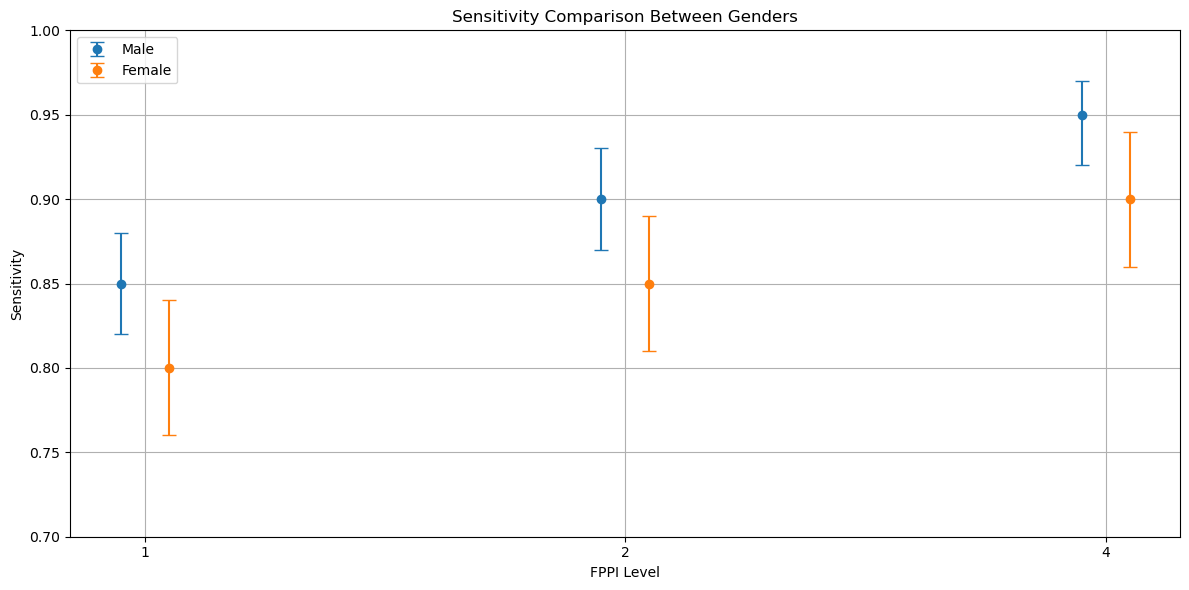

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Example summary statistics (mean, low, high) for Male and Female at each FPPI level
fppi_levels = [1, 2, 4]

# Example summary statistics (mean, low, high) for Male and Female
summary_male = {
    1: {'mean': 0.85, 'low': 0.82, 'high': 0.88},
    2: {'mean': 0.90, 'low': 0.87, 'high': 0.93},
    4: {'mean': 0.95, 'low': 0.92, 'high': 0.97}
}

summary_female = {
    1: {'mean': 0.80, 'low': 0.76, 'high': 0.84},
    2: {'mean': 0.85, 'low': 0.81, 'high': 0.89},
    4: {'mean': 0.90, 'low': 0.86, 'high': 0.94}
}

# Extracting data for plotting
means_male = np.array([summary_male[fppi]['mean'] for fppi in fppi_levels])
means_female = np.array([summary_female[fppi]['mean'] for fppi in fppi_levels])
errors_male = np.array([(summary_male[fppi]['mean'] - summary_male[fppi]['low'], summary_male[fppi]['high'] - summary_male[fppi]['mean']) for fppi in fppi_levels]).T
errors_female = np.array([(summary_female[fppi]['mean'] - summary_female[fppi]['low'], summary_female[fppi]['high'] - summary_female[fppi]['mean']) for fppi in fppi_levels]).T

# Plotting side-by-side scatter plots with error bars
plt.figure(figsize=(12, 6))

bar_width = 0.1
index = np.arange(len(fppi_levels))

plt.errorbar(index - bar_width/2, means_male, yerr=errors_male, fmt='o', label='Male', capsize=5)
plt.errorbar(index + bar_width/2, means_female, yerr=errors_female, fmt='o', label='Female', capsize=5)

plt.xlabel('FPPI Level')
plt.ylabel('Sensitivity')
plt.title('Sensitivity Comparison Between Genders')
plt.xticks(index, fppi_levels)
plt.legend()
plt.ylim(0.7, 1.0)  # Adjust ylim based on your data range

plt.grid(True)
plt.tight_layout()
plt.show()




# Calculate the number of model parameters

## MONAI Detection

In [2]:


import argparse
import gc
import json
import logging
import sys
import time

import cv2
import numpy as np
import torch
# from generate_transforms import (
#     generate_detection_train_transform,
#     generate_detection_val_transform,
# )
from torch.utils.tensorboard import SummaryWriter
# from visualize_image import visualize_one_xy_slice_in_3d_image
# from warmup_scheduler import GradualWarmupScheduler

import monai
from monai.apps.detection.metrics.coco import COCOMetric
from monai.apps.detection.metrics.matching import matching_batch
from monai.apps.detection.networks.retinanet_detector import RetinaNetDetector
from monai.apps.detection.networks.retinanet_network import (
    RetinaNet,
    resnet_fpn_feature_extractor,
)
from monai.apps.detection.utils.anchor_utils import AnchorGeneratorWithAnchorShape
from monai.data import DataLoader, Dataset, box_utils, load_decathlon_datalist
from monai.data.utils import no_collation
from monai.networks.nets import resnet
from monai.transforms import ScaleIntensityRanged
from monai.utils import set_determinism

gt_box_mode = "cccwhd"
lr = 1e-2
spacing = [0.703125, 0.703125, 1.25]
patch_size = [192,192,80]
val_patch_size = [512,512,208]
fg_labels = [0]
n_input_channels = 1
spatial_dims = 3
score_thresh = 0.02
nms_thresh = 0.22
returned_layers = [1,2]
conv1_t_stride = [2,2,1]
base_anchor_shapes = [[6,8,4],[8,6,5],[10,10,6]]
balanced_sampler_pos_fraction = 0.3



anchor_generator = AnchorGeneratorWithAnchorShape(
    feature_map_scales=[2**l for l in range(len(returned_layers) + 1)],
    base_anchor_shapes=base_anchor_shapes,
)

start_epoch = 0
conv1_t_size = [max(7, 2 * s + 1) for s in conv1_t_stride]
backbone = resnet.ResNet(
    block=resnet.ResNetBottleneck,
    layers=[3, 4, 6, 3],
    block_inplanes=resnet.get_inplanes(),
    n_input_channels=n_input_channels,
    conv1_t_stride=conv1_t_stride,
    conv1_t_size=conv1_t_size,
)
feature_extractor = resnet_fpn_feature_extractor(
    backbone=backbone,
    spatial_dims=spatial_dims,
    pretrained_backbone=False,
    trainable_backbone_layers=None,
    returned_layers=returned_layers,
)
num_anchors = anchor_generator.num_anchors_per_location()[0]
size_divisible = [s * 2 * 2 ** max(returned_layers) for s in feature_extractor.body.conv1.stride]
net = torch.jit.script(
    RetinaNet(
        spatial_dims=spatial_dims,
        num_classes=len(fg_labels),
        num_anchors=num_anchors,
        feature_extractor=feature_extractor,
        size_divisible=size_divisible,
    )
)


print(sum(p.numel() for p in net.parameters() if p.requires_grad))

20902741


# GRT123

In [7]:
from importlib import import_module
model = import_module('res18')
config, net, loss, get_pbb = model.get_model()

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

5383623
